In [1]:
%pylab inline
# next 2 lines allow to automatically reload modules that have been changed externally
%reload_ext autoreload
%autoreload 2
import os, sys
sys.path.insert(0, '/nobackup/jakravit/smartg-dev/smartg/')
from luts.luts import LUT, MLUT, Idx, merge, read_mlut

from smartg.albedo import Albedo_spectrum, Albedo_speclib, Albedo_cst
from smartg.bandset import BandSet
from smartg.smartg import Smartg, Sensor, multi_profiles, reduce_diff
from smartg.smartg import RoughSurface, LambSurface, FlatSurface, Environment, multi_profiles
from smartg.atmosphere import AtmAFGL, AeroOPAC, CompOPAC, CloudOPAC, diff1, read_phase, Species, trapzinterp
from smartg.water import IOP_1, IOP, IOP_profile, IOP_Rw, IOP_base
from smartg.reptran import REPTRAN, reduce_reptran
#from smartg.kdis import KDIS, reduce_kdis
from smartg.tools.tools import SpherIrr, Irr, reduce_Irr
from smartg.tools.cdf import ICDF
from smartg.tools.phase import integ_phase, calc_iphase

from smartg.tools.smartg_view import compare, plot_polar, spectrum , mdesc 
from smartg.tools.smartg_view import spectrum_view,transect_view,profile_view,phase_view,smartg_view,input_view
import warnings

from scipy.interpolate import interp1d
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
from smartg_int_library import *
from build_Case2 import build_Case2
import numpy as np
from scipy.interpolate import interp1d
import pickle
import pandas as pd


In [3]:
# Data paths 

# phytoplankton SIOP spectral library
path = '/nobackup/jakravit/data/EAP_phytoplankton_dataset/'
phy_library = {'Haptophytes': {}, 
               'Diatoms': {},
               'Dinoflagellates': {},
               'Cryptophytes': {},
               'Green_algae': {},
               'Cyano_blue': {},
               'Heterokonts': {},
               'Cyano_red': {},
               'Rhodophytes': {}
               }

for phy in phy_library:
    print (phy)
    with open(path+phy+'.p', 'rb') as fp:
        phy_library[phy] = pickle.load(fp)

# NAP spectral libraries
minpath = '/nobackup/jakravit/data/EAP_NAP_dataset/minerals_V2.p'
with open(minpath, 'rb') as fp:
    datamin = pickle.load(fp)  

detpath = '/nobackup/jakravit/data/EAP_NAP_dataset/det_V1.p'
with open(detpath, 'rb') as fp:
    datadet = pickle.load(fp) 

# Benthic library
benthic_lib = pd.read_csv('/nobackup/jakravit/data/benthic_spec_libary_FT_V4.csv')

# adjacency library
adj_lib = pd.read_csv('/nobackup/jakravit/data/adjacency_spectra_V2.csv')

# aeronet library
aero_lib = pd.read_csv('/nobackup/jakravit/data/aeronet_invdata_match.csv')

Haptophytes
Diatoms
Dinoflagellates
Cryptophytes
Green_algae
Cyano_blue
Heterokonts
Cyano_red
Rhodophytes


In [10]:
#----------------------------- START BUILDING ---------------------------------#

# Case
sname_title = 'case2_test'
INFO = True

# lambda
# l = np.arange(400, 902.5, 2.5)  
# Static data : IOPs wavelength grids
WAV = np.linspace(400, 900., num=201, dtype=np.float32)
WAV_CDOM = np.arange(240., 900., 2.5, dtype=np.float32)

# run names
snames = []
runlist = {}

# initiate df
df = pd.DataFrame()

# how many runs to build
# runs = 1
# for k in range(runs):
#     print (k)
    
# initiate iop dict
iops = build_Case2(phy_library, datamin, datadet, benthic_lib, adj_lib, aero_lib)

if INFO:
    print ('COMPONENTS:')
    for key in iops.keys():
        print (key)
    print ('\nChla: {} ug/L'.format(iops['Phyto']['TotChl']))
    print ('Minl: {} g/L'.format(iops['Min']['Tot_conc']))
    print ('ag440: {} m^-1'.format(iops['CDOM']['ag440']))
    print ('Max Depth: {} m'.format(iops['Depth']['Dmax']))

COMPONENTS:
VSF_angles
lambda
Phyto
Min
Det
CDOM
Depth
Benthic
Adjacency
Atm

Chla: 94.938 ug/L
Minl: 16.6668 g/L
ag440: 2.939 m^-1
Max Depth: 9.5 m


201


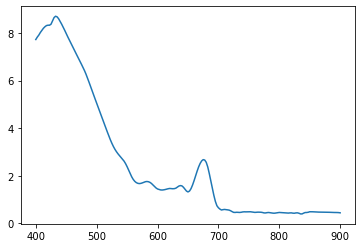

In [11]:
# get mixing IOP's
ap1,ac1,bp1,vsf1,angles = mix(iops)

# wavelength grid/slice for absorption and scattering coefficients
# wavelength grid for outputs
wavrange = slice(0,200,5)
wav      = WAV[wavrange]
# wavelength grid/slice for scattering matrices
wavrange_vsf = slice(0,200,20)
wav_vsf      = WAV[wavrange_vsf]
# vertical grid
Z = iops['Depth']['Depth']
# Z   = np.array([0, -2.5, -5., -10.])
xfactor = iops['Depth']['xfactor']
zeros = np.zeros_like(wav)

print(len(ap1))
fig, ax = plt.subplots()
ax.plot(WAV, ap1)

In [12]:
def read_awbw(dir_aux,WAV):
    from os.path import realpath, dirname, join
    from scipy.interpolate import griddata
    '''
    Read pure water absorption from pope&fry, 97 (<700nm)
    and palmer&williams, 74 (>700nm)
    '''

    # Pope&Fry
    with open(join(dir_aux, 'water','data', 'pope97.dat'), 'rb') as fp:
        for i in range(6): fp.readline()  # skip the first 6 lines
        data_pf = np.genfromtxt(fp)
    aw_pf = data_pf[:,1] * 100 #  convert from cm-1 to m-1
    lam_pf = data_pf[:,0]
    ok_pf = lam_pf <= 725

    # Palmer&Williams
    data_pw = np.genfromtxt(join(dir_aux, 'water', 'data','palmer74.dat'), skip_header=5)
    aw_pw = data_pw[::-1,1] * 100 #  convert from cm-1 to m-1
    lam_pw = data_pw[::-1,0]
    ok_pw = lam_pw > 725

    # aw = LUT(
    #         np.array(list(aw_pf[ok_pf]) + list(aw_pw[ok_pw])),
    #         axes=[np.array(list(lam_pf[ok_pf]) + list(lam_pw[ok_pw]))]
    #         )
    
    aw = np.array(list(aw_pf[ok_pf]) + list(aw_pw[ok_pw]))
    l = [np.array(list(lam_pf[ok_pf]) + list(lam_pw[ok_pw]))]
    
    awi = griddata(l[0], aw, WAV)
    bwi = 19.3e-4*((WAV[:]/550.)**-4.3)
    
    return awi, bwi

aw, bw = read_awbw('/nobackup/jakravit/smartg-dev/smartg/smartg/tools/', WAV)

print (len(aw))
print (len(bw))

201
201


 Datasets:
  [0] T_oc (float32 in [280, 280]), axes=('z_oc',)
  [1] phase_oc (float64 in [0, 52.1]), axes=('iphase', 'stk', 'theta_oc')
  [2] iphase_oc (int32 in [0, 199]), axes=('wavelength', 'z_oc')
  [3] OD_w (float64 in [-54.5, 0]), axes=('wavelength', 'z_oc')
  [4] OD_p_oc (float64 in [-25.1, 0]), axes=('wavelength', 'z_oc')
  [5] OD_y (float64 in [-80.7, 0]), axes=('wavelength', 'z_oc')
  [6] OD_oc (float64 in [-103, 0]), axes=('wavelength', 'z_oc')
  [7] OD_sca_oc (float64 in [-19, 0]), axes=('wavelength', 'z_oc')
  [8] OD_abs_oc (float64 in [-88.6, 0]), axes=('wavelength', 'z_oc')
  [9] pine_oc (float64 in [0, 0]), axes=('wavelength', 'z_oc')
  [10] pmol_oc (float32 in [2.63e-05, 1]), axes=('wavelength', 'z_oc')
  [11] ssa_oc (float64 in [0.00126, 1]), axes=('wavelength', 'z_oc')
  [12] ssa_p_oc (float32 in [0.629, 1]), axes=('wavelength', 'z_oc')
  [13] ssa_w (float64 in [4.3e-05, 0.595]), axes=('wavelength', 'z_oc')
  [14] FQY1_oc (float64 in [0, 0]), axes=('wavelength', 'z_o

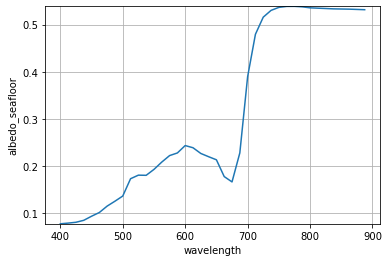

In [13]:
#IOP's profiles
bp_list = [bp1[wavrange] * x for x in xfactor] 
ap_list = [ap1[wavrange] * x for x in xfactor]
ac_list = [ac1[wavrange] * x for x in xfactor]
xfactorvsf = [1 if x==0 else x for x in xfactor]
vsf_list = [vsf1[:,wavrange_vsf,:] * x for x in xfactorvsf]
aw_list = [aw[wavrange]] * len(xfactor)
bw_list = [bw[wavrange]] * len(xfactor)
# aw_list = None # use SMART-G default pure water absorption
# bw_list = None # use SMART-G default pure water scattering

# Albedos speclib library inputs    
bALB = Albedo_spectrum2(iops['Benthic']['Tot'])
aALB = Albedo_speclib2(iops['Adjacency']['Tot'])

# water MLUT building
# VSF truncation at 10 deg
# seafloor from mixing model
water   = import_iop(ap_list, bp_list, ac_list, vsf_list, wav, wav_vsf, Z, angles, 
                    aw_list=aw_list, bw_list=bw_list, ang_trunc=10.,  ALB=bALB).describe()

water['albedo_seafloor'].plot()

In [14]:
# Goal: to simulate an observation from a satellite sensor 
# for 1 thv and 1 azimuth
# with a straight coastline (limit ocean land at x=0, ocean for x <0)
# the sensor is looking to a water pixel located at a distance 'dist' from the coastline
# we simulate a coastline as being the zone near a big circle, whose radius is 1e6 km
# centred on a point located far from the sensor (-1e6 km from the origin )
# The interior of the circle is the ocean

# Ocean surface
surf=RoughSurface(WAVE_SHADOW=True, WIND=12.)

# Land environment
D       = 5 #(km)
# The Environement object creates a disk of ocean surface with radius ENV_SIZE
# centred on X0,Y0 , surrounded by lambertian reflector of albedo ALB
env     = Environment(ENV=1, 
                  ENV_SIZE= D ,       # radius of the circle with ocean surface condition
                  X0= -D,             # X coordinate of the center of the circle
                  Y0= 0,
                  ALB=aALB # adjacency mixing model
                 )

#Observer
HTOA   = 120.
VZA    = iops['Atm']['VZA']
VAA    = iops['Atm']['VAA']
dist   = 0.1 # distance to the coast(km)
DeltaH = HTOA   * np.tan(np.radians(VZA))
DeltaX = DeltaH * np.cos(np.radians(180-VAA))
DeltaY = DeltaH * np.sin(np.radians(180-VAA))
sensor_TOA = Sensor(
    POSX = -dist + DeltaX,      # Sensor coordinates (in km) (default:origin(0.,0.,0.))
    POSY = DeltaY,
    POSZ = HTOA,
    THDEG= 180-VZA, # Sensor 'Emitting' zenith angle, from 0: Zenith to 180.: Nadir (default:0.)
    PHDEG= VAA,     # Sensor 'Emitting' azimuth angle (default:0.)
    LOC  = 'ATMOS', # location of sensor (default: (SURF0P, just above surface)
    FOV  = 0.,      # Sensor FOV (default 0.)
    TYPE = 0        # Sensor type :Radiance (0), Planar flux (1), Spherical Flux (2), (default 0)
    )
sensor_BOA = Sensor(THDEG=180-VZA, PHDEG=VAA, TYPE=0, LOC='ATMOS')

# Atmosphere
# to be computed at eh same wavlegnth grid as water IOP's

# monochromatic computation for custom aerosols and cloud
wlref = 440.
# Aerosols and cloud optical properties using OPAC database as processed by the the libradtran (www.libradtran.org)
aer = AeroOPAC( iops['Atm']['aero_prof'], 
                iops['atm']['aero'].loc[:,'AOD_Coincident_Input[440nm]'].values, 
                wlref,
                ssa = iops['Atm']['aero'].loc[:,'Single_Scattering_Albedo[440nm]'].values
              ) 
                                
                                                              
atm = AtmAFGL(atm_filename = iops['Atm']['atm_prof'],    # atmosphere profile
              comp=[aer], # no clouds, only aerosols          
              O3 = 0.,   # scale ozone vertical column to 0 Dobson units (here no absoprtion by ozone)
              NO2= False,# disable absorption by NO2
              H2O= 2.,   # scale water vapour column to 2 g/cm-2, but no H2O absoprtion, just hygroscopic computation for aerosols
              P0 = 980., # set sea level pressure to 980 hPa
              tauR=0.1,   # force Rayleigh optical thickness
              grid =   [100., 75., 50., 25., 15., 10., 5., 3., 2., 1.15], # set vertical grid, surface altitude at 1.15 km
              pfgrid = [100., 25., 15., 10., 5., 3., 2., 1.15], # vertical grid for the computation of particles phase functions
              pfwav=wav_vsf
             ).calc(wav).describe()

# atm = AtmAFGL(atm=pro,  
#               pfwav=wav_vsf).calc(wav).describe()

 Datasets:
  [0] n_atm (float64 in [1, 1]), axes=('wavelength', 'z_atm')
  [1] T_atm (float32 in [200, 333]), axes=('z_atm',)
  [2] OD_r (float64 in [5.67e-10, 0.362]), axes=('wavelength', 'z_atm')
  [3] OD_p (float32 in [0, 0.291]), axes=('wavelength', 'z_atm')
  [4] ssa_p_atm (float32 in [0.825, 1]), axes=('wavelength', 'z_atm')
  [5] OD_g (float64 in [-0, 0.0558]), axes=('wavelength', 'z_atm')
  [6] OD_atm (float64 in [5.67e-10, 0.657]), axes=('wavelength', 'z_atm')
  [7] OD_sca_atm (float64 in [0, 0.626]), axes=('wavelength', 'z_atm')
  [8] OD_abs_atm (float64 in [0, 0.0744]), axes=('wavelength', 'z_atm')
  [9] ssa_atm (float64 in [0.0643, 1]), axes=('wavelength', 'z_atm')
  [10] pmol_atm (float64 in [0.0341, 1]), axes=('wavelength', 'z_atm')
  [11] pine_atm (float64 in [0, 0]), axes=('wavelength', 'z_atm')
  [12] FQY1_atm (float64 in [0, 0]), axes=('wavelength', 'z_atm')
  [13] phase_atm (float64 in [-0.441, 181]), axes=('iphase', 'stk', 'theta_atm')
  [14] iphase_atm (int32 in [0

In [ ]:
%%time
# Backward Local Estimate -> Solar geometries
#le  = {'th_deg':np.linspace(0,85,num=12), 'phi_deg':np.linspace(0,360,num=18)}
le  = {'th_deg':np.linspace(30,60,num=2), 'phi_deg':np.linspace(0,360,num=9)}
alis=True
alis_options={'nlow':-1} if alis else None

mB =Smartg(device=0, back=True, alt_pp=False, alis=alis).run(wl=wav, water=water, 
                                atm=atm, surf=surf, 
                                NBPHOTONS=1e7, sensor=sensor_TOA, NF=1e3, alis_options=alis_options,
                                le=le, OUTPUT_LAYERS=3,)

In [16]:
mB.print_info()

 Datasets:
  [0] I_up (TOA) (float64 in [0.0405, 0.261]), axes=('wavelength', 'Azimuth angles', 'Zenith angles')
  [1] Q_up (TOA) (float64 in [-0.108, 0.0807]), axes=('wavelength', 'Azimuth angles', 'Zenith angles')
  [2] U_up (TOA) (float64 in [-0.103, 0.0927]), axes=('wavelength', 'Azimuth angles', 'Zenith angles')
  [3] V_up (TOA) (float64 in [-0.000169, 0.000161]), axes=('wavelength', 'Azimuth angles', 'Zenith angles')
  [4] N_up (TOA) (uint64 in [6.3e+05, 1.33e+06]), axes=('wavelength', 'Azimuth angles', 'Zenith angles')
  [5] direct transmission (float64 in [0.518, 0.889]), axes=('wavelength',)
  [6] n_atm (float64 in [1, 1]), axes=('wavelength', 'z_atm')
  [7] T_atm (float32 in [200, 333]), axes=('z_atm',)
  [8] OD_r (float64 in [5.67e-10, 0.362]), axes=('wavelength', 'z_atm')
  [9] OD_p (float32 in [0, 0.291]), axes=('wavelength', 'z_atm')
  [10] OD_g (float64 in [-0, 0.0558]), axes=('wavelength', 'z_atm')
  [11] OD_atm (float64 in [5.67e-10, 0.657]), axes=('wavelength', 'z_atm

In [17]:
iup = mB[0]
print (iup)
print (iup.shape)

(40, 9, 2)


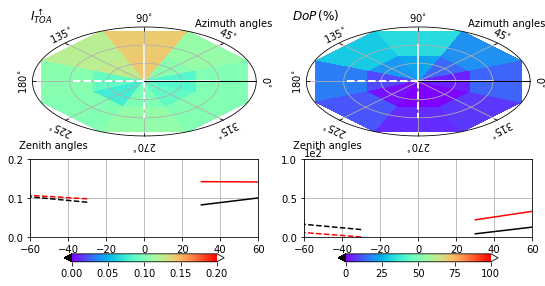

In [18]:
_=smartg_view(mB.sub( d={'wavelength':Idx(750)}), field='up (TOA)', ind=[0,2], Imax=0.2, Imin=0)

In [48]:
f=spectrum_view(mB,  subdict={'Zenith angles':Idx(60), 'Azimuth angles':Idx(90)}, full=False, vmax=0.2, vmin=0)

ValueError: Single argument to subplot must be a three-digit integer, not '121'

<Figure size 576x288 with 0 Axes>

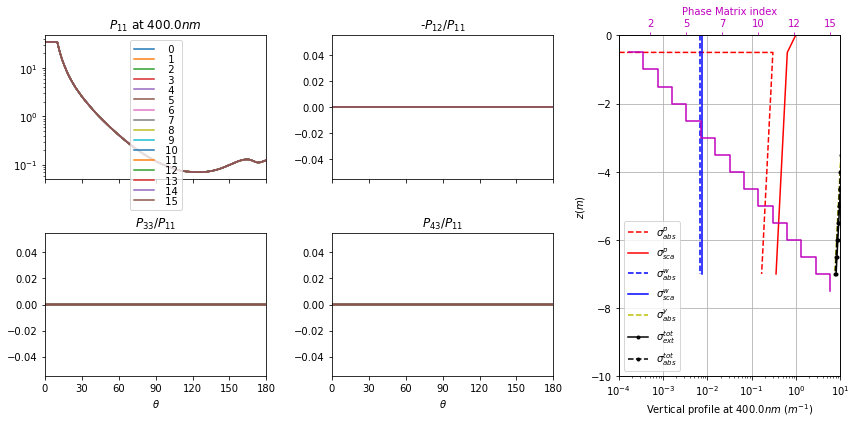

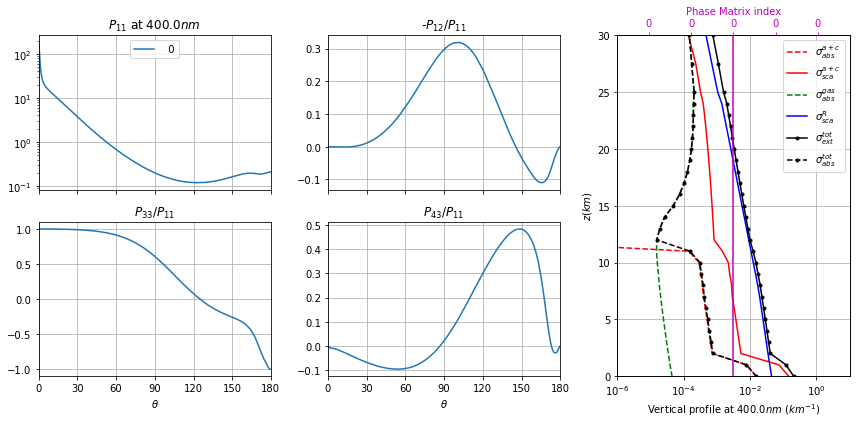

In [49]:
_=input_view(mB, kind='oc', zmax=-10)
_=input_view(mB, kind='atm', zmax=30)